In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/50] - Train Loss: 0.3834, Train Acc: 0.8088, Val Loss: 0.4396, Val Acc: 0.7644
Epoch [2/50] - Train Loss: 0.2156, Train Acc: 0.9029, Val Loss: 0.2547, Val Acc: 0.9041
Epoch [3/50] - Train Loss: 0.1778, Train Acc: 0.9223, Val Loss: 0.2166, Val Acc: 0.9178
Epoch [4/50] - Train Loss: 0.1374, Train Acc: 0.9468, Val Loss: 0.1996, Val Acc: 0.9205
Epoch [5/50] - Train Loss: 0.1066, Train Acc: 0.9576, Val Loss: 0.6553, Val Acc: 0.7726
Epoch [6/50] - Train Loss: 0.1302, Train Acc: 0.9458, Val Loss: 0.2045, Val Acc: 0.9315
Epoch [7/50] - Train Loss: 0.0703, Train Acc: 0.9729, Val Loss: 0.2110, Val Acc: 0.9233
Epoch [8/50] - Train Loss: 0.0625, Train Acc: 0.9749, Val Loss: 0.2300, Val Acc: 0.9068
Epoch [9/50] - Train Loss: 0.0681, Train Acc: 0.9688, Val Loss: 0.3278, Val Acc: 0.9178
Epoch [10/50] - Train Loss: 0.0520, Train Acc: 0.9826, Val Loss: 0.2374, Val Acc: 0.9370
Epoch [11/50] - Train Loss: 0.0462, Train Acc: 0.9857, Val Loss: 0.1910, Val Acc: 0.9315
Epoch [12/50] - Train Loss: 0.

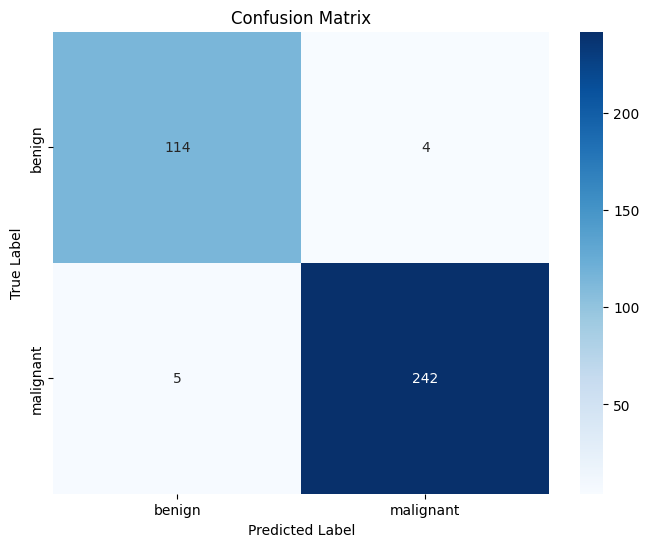

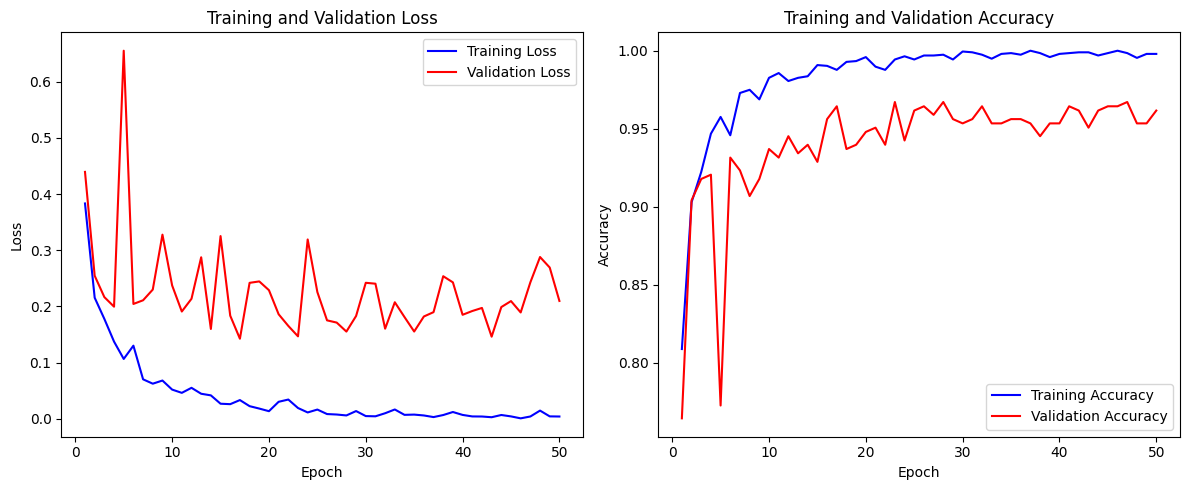

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timm import create_model
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to training and test datasets
train_path = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/train'
test_path = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/test'

# Model parameters
img_size = 224
batch_size = 32
num_classes = 2  # Binary classification for benign/malignant
learning_rate = 1e-4
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data augmentation and transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Feature extractor: Pre-trained ViT
vit_model = create_model('vit_base_patch16_224', pretrained=True)
vit_model = vit_model.to(device)

# Unfreeze last few layers of ViT for fine-tuning
for name, param in vit_model.named_parameters():
    if "blocks" in name or "norm" in name:
        param.requires_grad = True

# Define CNN classifier with dropout layer
class CNNClassifier(nn.Module):
    def __init__(self, vit_dim=768, num_classes=2):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=vit_dim, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(50432, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

cnn_classifier = CNNClassifier().to(device)

# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_classifier.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs // 2, gamma=0.5)

# For storing metrics
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Hybrid training loop
for epoch in range(num_epochs):
    cnn_classifier.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            vit_features = vit_model.forward_features(data)

        optimizer.zero_grad()
        outputs = cnn_classifier(vit_features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    # Save metrics
    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation
    cnn_classifier.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            vit_features = vit_model.forward_features(data)
            outputs = cnn_classifier(vit_features)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)
    scheduler.step()  # Update learning rate according to the scheduler

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Evaluation metrics
cnn_classifier.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        vit_features = vit_model.forward_features(data)
        outputs = cnn_classifier(vit_features)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_targets, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_loader.dataset.classes,
            yticklabels=test_loader.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Training and Validation Loss/Accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
